### Import libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import kagglehub
warnings.filterwarnings("ignore")

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nelakurthisudheer/mall-customer-segmentation")

In [3]:
df = pd.read_csv(path + '/Mall_Customers.csv')

In [4]:
df.head(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


### First Glance

In [5]:
df.shape

(200, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [7]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


### Data Checking

In [8]:
for columns in df.columns:
    if df[columns].dtype == 'object':
        print(f"{columns} : {df[columns].unique()}")
    else:
        print(f"{columns} : {df[columns].nunique()} unique values")

CustomerID : 200 unique values
Gender : ['Male' 'Female']
Age : 51 unique values
Annual Income (k$) : 64 unique values
Spending Score (1-100) : 84 unique values


-> 200 unique customers

In [9]:
df["CustomerID"].nunique()

200

### EDA

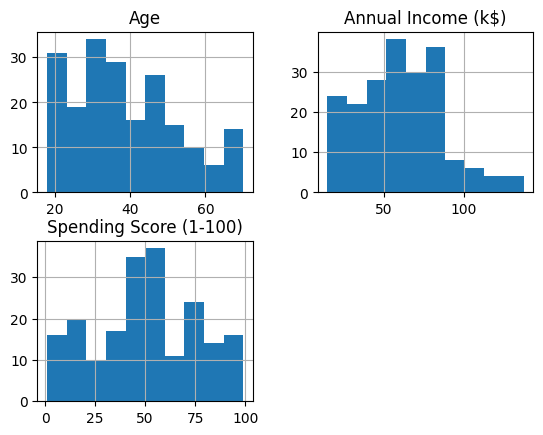

In [10]:
df.iloc[:,1:].hist();

-> Tương đối ít outliers, không cần xử lý

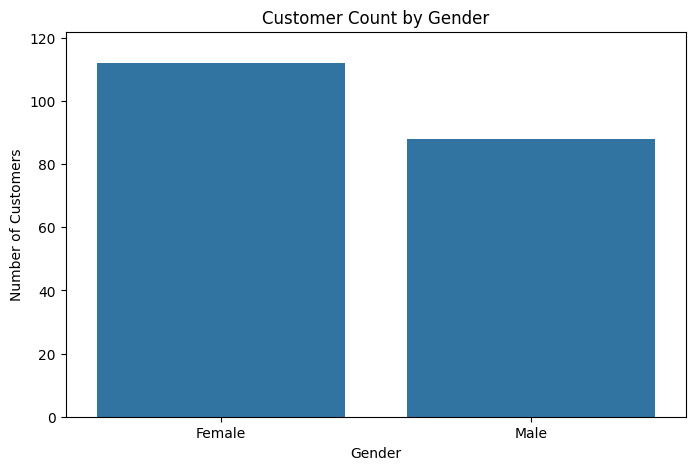

In [11]:
# Giới tính nào có vẻ thích mua sắm hơn ?
# Trước tiên ta xem số lượng mẫu nam - nữ
sex_count = df.groupby("Gender")["CustomerID"].nunique()

plt.figure(figsize=(8, 5))
sns.barplot(x=sex_count.index, y=sex_count.values)
plt.xlabel("Gender")
plt.ylabel("Number of Customers")
plt.title("Customer Count by Gender")
plt.ylim(0, sex_count.values.max() + 10)
plt.show()

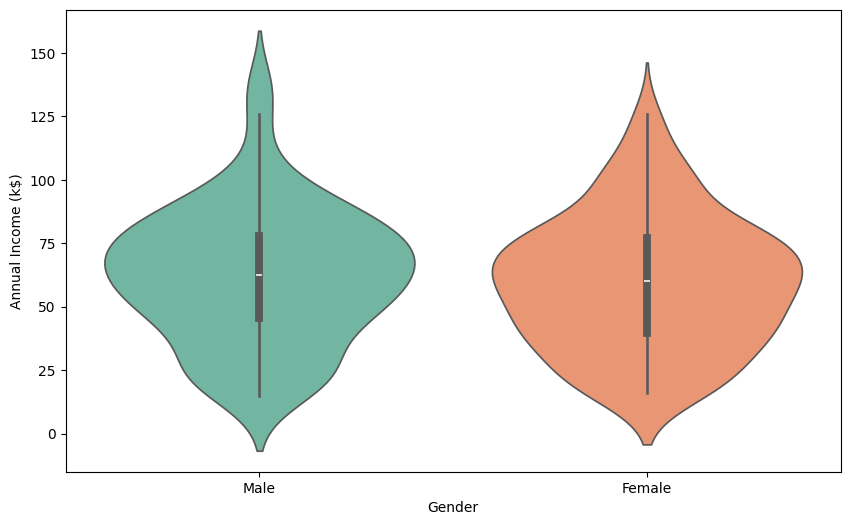

In [12]:
# Không quá chênh lệch nam nũ, ta xem xem nam hay nữ có điểm chi tiêu nhiều hơn
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x="Gender", y="Annual Income (k$)", palette="Set2")
plt.show()

In [13]:
# -> Thật bất ngờ khi nam có vẻ chi tiêu nhiều hơn nữ, tuy nhiên không quá chênh lệch
# Về hình dáng của violin thì ta thấy dường như nữ có vẻ chịu chi mạnh tay hơn nam khi ta để ý từ khoảng 90 trở lên thì nữ rộng hơn (violin bành ra) hơn nhiều.
# Tuy nhiên, nam thì tồn tại vài điểm đột biến cao hơn 150.

Thu nhập càng cao chi tiêu càng nhiều ?

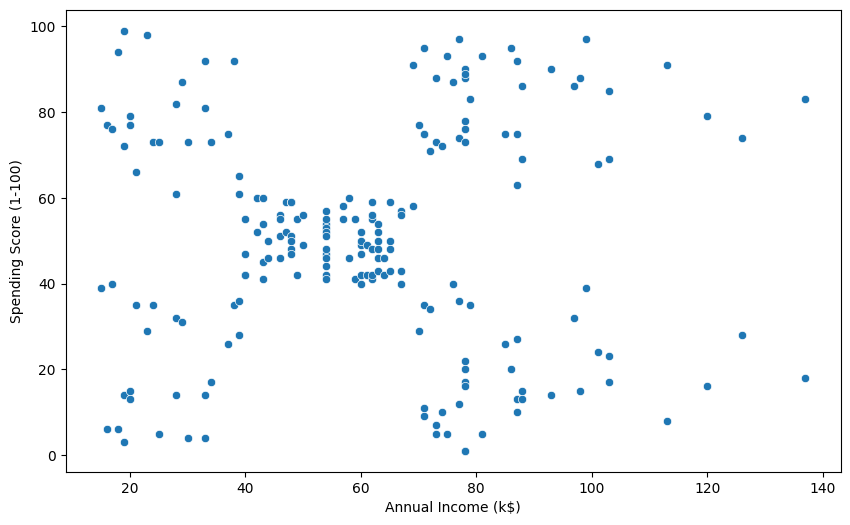

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Annual Income (k$)", y="Spending Score (1-100)")
plt.show()

In [15]:
#-> Không phải mối quan hệ tuyến tính. Tuy nhiên dường như ở đây ta có thể nhìn thấy các cụm nằm riêng lẻ

In [16]:
# Loại bỏ cột không cần thiết
df.drop(columns=["CustomerID"], inplace=True)

### Phân cụm

#### TH1: Phân cụm dựa trên 2 biến: Age và Spending Score

In [17]:
# Không cần chuẩn hóa vì 2 features này có đơn vị đo lường gần như nhau

In [18]:
df_age_spending = df[["Age", "Spending Score (1-100)"]]

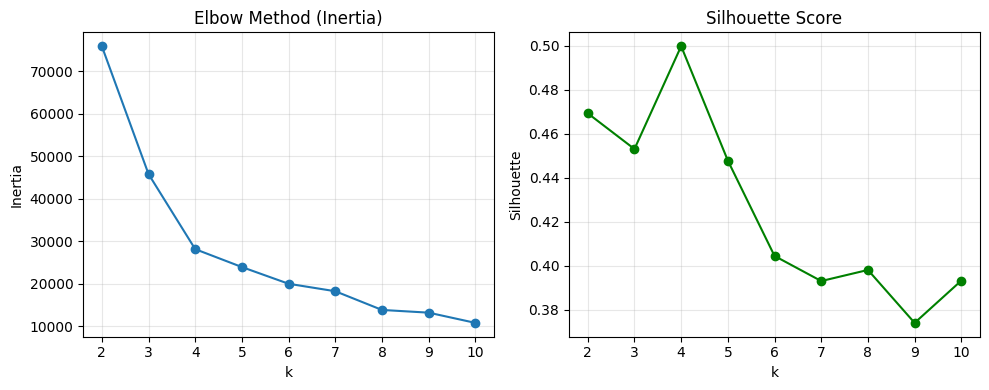

In [19]:
def find_optimal_k(X, max_k=10):
    inertias = []
    silhouettes = []

    # compute inertia and silhouette for k >= 2
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X, labels))

    ks = np.arange(2, max_k + 1)

    plt.figure(figsize=(10, 4))

    # Elbow (Inertia)
    plt.subplot(1, 2, 1)
    plt.plot(ks, inertias, marker='o')
    plt.title('Elbow Method (Inertia)')
    plt.xlabel('k')
    plt.ylabel('Inertia')
    plt.grid(True, alpha=0.3)

    # Silhouette
    plt.subplot(1, 2, 2)
    plt.plot(ks, silhouettes, marker='o', color='green')
    plt.title('Silhouette Score')
    plt.xlabel('k')
    plt.ylabel('Silhouette')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

find_optimal_k(df_age_spending, max_k=10)

-> Số cụm tối ưu là 4

In [20]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(df_age_spending)
df_age_spending['Cluster'] = kmeans.labels_

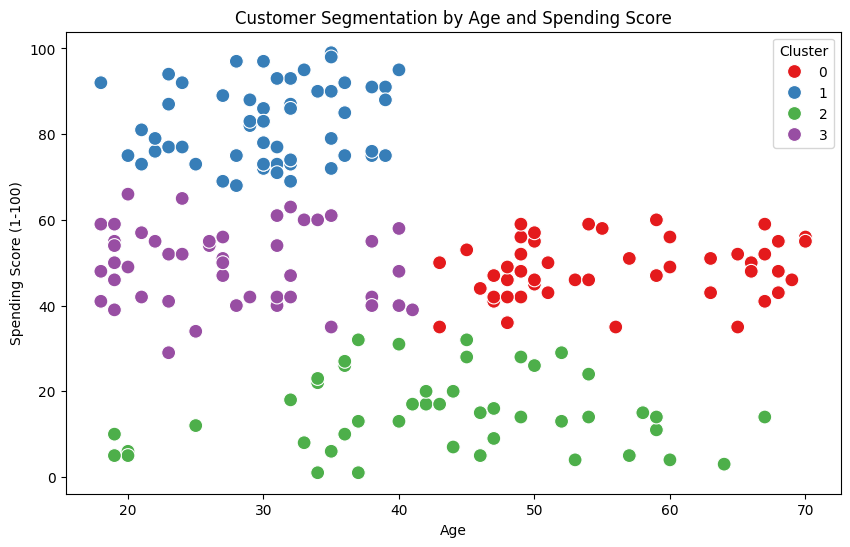

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_age_spending, x="Age", y="Spending Score (1-100)", hue="Cluster", palette="Set1", s=100)
plt.title("Customer Segmentation by Age and Spending Score")
plt.show()

+ Cụm Spending cao – Tuổi trẻ (Age thấp, Score cao): Cluster 1

+ Cụm Spending trung bình – Tuổi trẻ (Age thấp, Score trung bình): Cluster 3

+ Cụm Spending trung bình – Tuổi trung niên (Age trung bình, Score cao): Cluster 0

+ Cụm Spending thấp – Tuổi 30+ (Age trung bình-cao, Score thấp–trung): Cluster 2

In [22]:
df["Spend_Age_Segment"] = df_age_spending['Cluster']

In [23]:
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),Spend_Age_Segment
0,Male,19,15,39,3
1,Male,21,15,81,1
2,Female,20,16,6,2
3,Female,23,16,77,1
4,Female,31,17,40,3


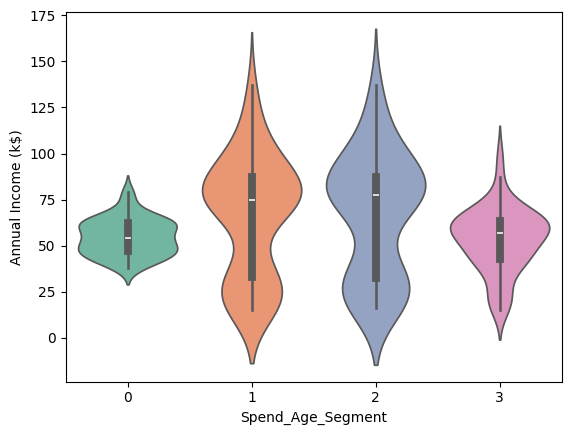

In [24]:
sns.violinplot(data=df, x="Spend_Age_Segment", y="Annual Income (k$)", palette="Set2");

Nhóm 1,2 có thu nhập nhỉnh hơn các nhóm 0,3. 

Nhóm 0 dường như tập trung nhiều vào nhóm người có thu nhập trung bình. Mặc dù vậy các box vẫn có sự chồng lấn với nhau, không thể phân biệt rõ ràng.

#### **Chiến lược hành động cho từng cụm khách hàng**

**1. Cụm 0: Thu nhập trung bình, chi tiêu trung bình, tuổi cao**  

**Đặc điểm:** Khách hàng trung niên/cao tuổi, thu nhập ổn định, chi tiêu cân đối
**Chiến lược:**
- Tập trung vào sản phẩm chất lượng, bền vững
- Chương trình khuyến mãi dài hạn, tích điểm
- Dịch vụ chăm sóc khách hàng chu đáo
- Marketing qua kênh truyền thống (TV, báo chí)

**2. Cụm 1: Thu nhập trung bình - cao, chi tiêu cao, tuổi trẻ**  

**Đặc điểm:** Khách hàng trẻ tuổi, có tiềm lực tài chính, thích chi tiêu
**Chiến lược:**
- Sản phẩm cao cấp, xu hướng mới
- Flash sale, limited edition
- Marketing qua social media, influencer
- Chương trình VIP, early access
- Cross-selling và up-selling tích cực

**3. Cụm 2: Thu nhập trung bình - cao, chi tiêu thấp, tuổi trung niên - cao**  

**Đặc điểm:** Khách hàng có thu nhập nhưng tiết kiệm, thận trọng trong chi tiêu
**Chiến lược:**
- Nhấn mạnh giá trị, tính kinh tế
- Khuyến mãi theo số lượng (buy more, save more)
- Sản phẩm thiết yếu, chất lượng tốt
- Chương trình cashback, hoàn tiền
- Thông tin chi tiết về lợi ích sản phẩm

**4. Cụm 3: Thu nhập trung bình, chi tiêu trung bình, tuổi trẻ**  

**Đặc điểm:** Khách hàng trẻ, thu nhập chưa cao, chi tiêu cân đối
**Chiến lược:**
- Sản phẩm giá cả phải chăng
- Chương trình trả góp, thanh toán linh hoạt
- Bundle deals, combo ưu đãi
- Marketing qua digital channels
- Chương trình loyalty để giữ chân khách hàng lâu dài

#### TH2: Phân cụm dựa trên 2 biến: Annual Income và Spending Score

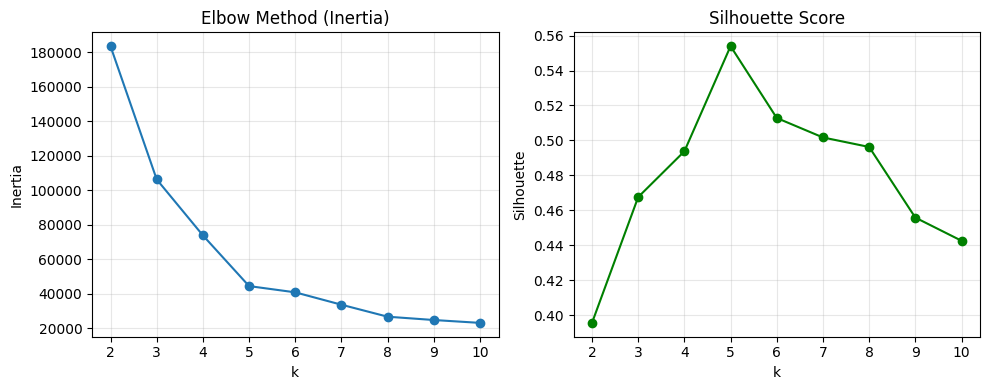

In [25]:
df_income_spending = df[["Annual Income (k$)", "Spending Score (1-100)"]]

find_optimal_k(df_income_spending, max_k=10)

-> Optimal k là 5

In [26]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(df_income_spending)
df_income_spending['Cluster'] = kmeans.labels_

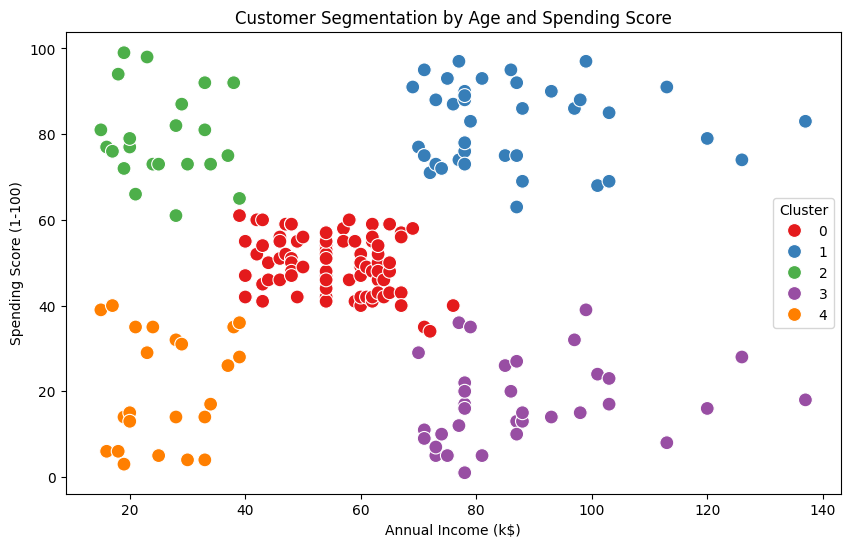

In [27]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_income_spending, x="Annual Income (k$)", y="Spending Score (1-100)", hue="Cluster", palette="Set1", s=100)
plt.title("Customer Segmentation by Age and Spending Score")
plt.show()

#### Tên và mô tả các cụm (Annual Income vs Spending Score)

- **Cụm 0 (màu đỏ)**: Thu nhập trung bình, chi tiêu trung bình – "Trung lưu ổn định"
- **Cụm 1 (màu xanh dương)**: Thu nhập cao, chi tiêu cao – "Khách VIP"
- **Cụm 2 (màu xanh lá)**: Thu nhập thấp, chi tiêu cao – "Khách trẻ tiềm năng"
- **Cụm 3 (màu tím)**: Thu nhập cao, chi tiêu thấp – "Người tiết kiệm"
- **Cụm 4 (màu cam)**: Thu nhập thấp, chi tiêu thấp – "Khách giá rẻ"

In [28]:
df["Income_Spend_Segment"] = kmeans.labels_

#### Ta phân tích thêm:

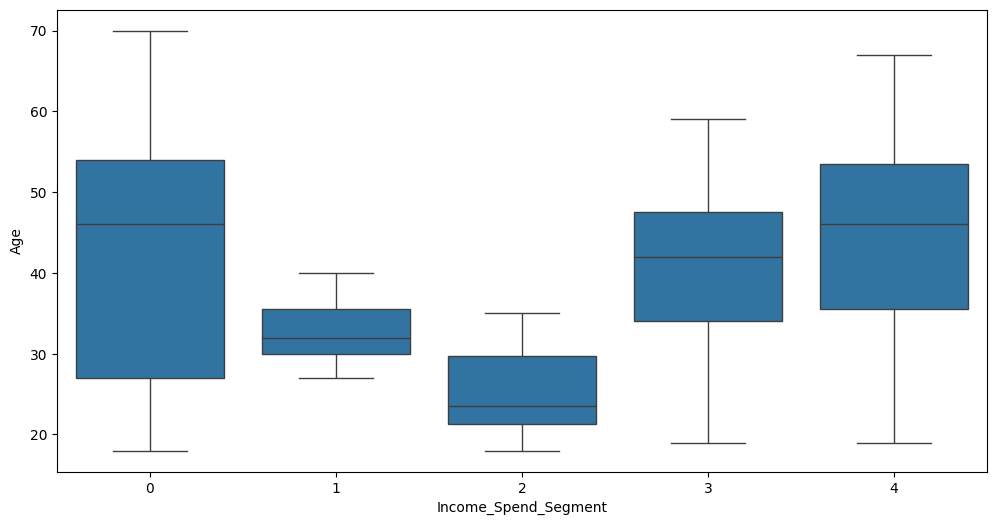

In [37]:
# Số lượng nam/nữ phân bổ trong từng cụm
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="Income_Spend_Segment",y="Age")
plt.show()

-> Không rõ ràng lắm

#### TH3: Phân cụm dựa trên 3 biến: Annual Income,Spending Score và Age

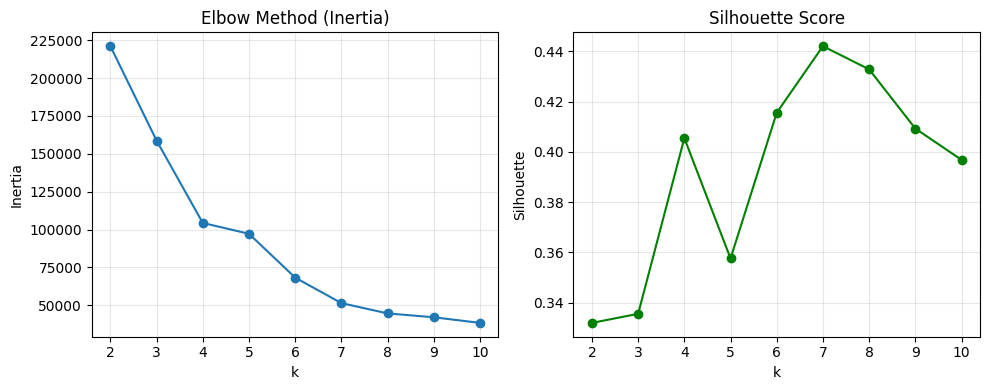

In [39]:
find_optimal_k(df[["Annual Income (k$)", "Spending Score (1-100)", "Age"]], max_k=10)

-> Ta chọn 4 hoặc là 7.

Tôi sẽ chọn 4 vì có vẻ 7 hơi nhiều, mặt khác 4 cụm này thì giống với bài toán trên tôi cũng phân được thành 4

In [40]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(df[["Annual Income (k$)", "Spending Score (1-100)", "Age"]])
df["Income_Spend_Age_Segment"] = kmeans.labels_

In [ ]:
import plotly.express as px
fig = px.scatter_3d(df, x="Annual Income (k$)", y="Spending Score (1-100)", z="Age",
                    color="Income_Spend_Age_Segment", title="3D Scatter Plot of Customer Segments",
                    labels={"Income_Spend_Age_Segment": "Segment"},
                    color_continuous_scale=px.colors.qualitative.Set1)
fig.update_traces(marker=dict(size=5))
fig.show()

#### Đặt tên nhóm & Kế hoạch hành động (kết luận 4 nhóm)

- Segment 0 — "Trung lưu cân bằng": Chi tiêu trung bình, thu nhập trung bình, hiện diện ở nhiều độ tuổi.
  - Action:
    - Sản phẩm chủ lực/giá trị tốt, combo tiết kiệm.
    - Chương trình tích điểm, ưu đãi theo giỏ hàng.
    - Email remarketing theo mùa vụ, voucher quay lại.

- Segment 1 — "VIP bạo chi": Thu nhập cao, chi tiêu cao, trẻ.
  - Action:
    - Dòng cao cấp, limited/early access, personalization.
    - VIP tiering, concierge, ưu đãi sinh nhật/sự kiện.
    - Influencer/UGC, flash sale độc quyền, upsell-bundle cao cấp.

- Segment 2 — "Trẻ ham deal": Chi tiêu cao nhưng thu nhập thấp (nhạy giá).
  - Action:
    - Flash sale, BNPL/trả góp, miễn phí vận chuyển.
    - Gợi ý sản phẩm theo trend, mini-bundle giá tốt.
    - Tập trung kênh social/TikTok Shop, referral program.

- Segment 3 — "Tiết kiệm thận trọng": Thu nhập cao, chi tiêu thấp, trung niên.
  - Action:
    - Nhấn mạnh độ bền/ROI, bảo hành mở rộng.
    - Mua nhiều giảm sâu cho hàng thiết yếu.
    - Nội dung so sánh, review chuyên gia, catalog offline.